In [20]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt

movies = pd.read_csv('ml-latest-small/movies.csv')

ratings = pd.read_csv('ml-latest-small/ratings.csv')

tags = pd.read_csv('ml-latest-small/tags.csv')

In [21]:
import warnings
warnings.filterwarnings('ignore')

Data inspection

In [22]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [23]:
ratings = ratings.drop('timestamp' , axis=1)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [24]:
tags = tags.drop('timestamp', axis=1)
tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [25]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


Data manipulation

In [26]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    genre_ratings = pd.concat([genre_ratings,pd.DataFrame(set(ratings['userId']))], axis=1)
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi', 'Adventure'], ['userId', 'Romance', 'Sci-Fi', 'Adventure'])
genre_ratings.head()


,userId,Romance,Sci-Fi,Adventure
0,1.0,NaN,NaN,NaN
1,2.0,4.31,4.22,4.39
2,3.0,4.50,3.88,4.17
3,4.0,0.50,4.20,2.73
4,5.0,3.38,2.83,3.66


In [27]:
#Delete the rows with NaN values
genre_ratings = genre_ratings.dropna()

In [28]:
def get_tag_ratings(ratings, tag_data, tags, column_names):
    #tag_data = tag_data.dropna()
    tag_ratings = pd.DataFrame()
    tag_ratings = pd.concat([tag_ratings,pd.DataFrame(set(ratings['userId']))], axis=1)
    for tag in tags:        
        tag_movies = tag_data[tag_data['tag'].str.contains(tag) ]
        avg_tag_votes_per_user = ratings[ratings['movieId'].isin(tag_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        tag_ratings = pd.concat([tag_ratings, avg_tag_votes_per_user], axis=1)
        
    tag_ratings.columns = column_names
    return tag_ratings

# Calculate the average rating of funny and fantasy movies
tag_ratings = get_tag_ratings(ratings, tags, ['funny', 'fantasy', 'mafia'], ['userId', 'funny', 'fantasy', 'mafia'])
tag_ratings.head()


,userId,funny,fantasy,mafia
0,1.0,NaN,NaN,NaN
1,2.0,4.00,NaN,NaN
2,3.0,3.83,NaN,NaN
3,4.0,NaN,NaN,NaN
4,5.0,2.50,NaN,NaN


In [29]:
#delete rows containing NaN values
tag_ratings = tag_ratings.dropna()

Biasing dataset to obtain a more delimited subset of people

In [30]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    return genre_ratings[((genre_ratings['Romance'] < score_limit_1 - 0.2) & (genre_ratings['Sci-Fi'] > score_limit_2)) | ((genre_ratings['Sci-Fi'] < score_limit_1) & (genre_ratings['Romance'] > score_limit_2))]
# Bias the dataset
genre_ratings_biased = bias_genre_rating_dataset(genre_ratings, 3.5, 2.3)
genre_ratings_biased = genre_ratings_biased.reset_index(drop=True)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(genre_ratings_biased))

Number of records:  294


In [31]:
def bias_tag_rating_dataset(tag_ratings, score_limit_1, score_limit_2):
    return tag_ratings[((tag_ratings['funny'] < score_limit_1 - 0.2) & (tag_ratings['fantasy'] > score_limit_2)) | ((tag_ratings['fantasy'] < score_limit_1) & (tag_ratings['funny'] > score_limit_2))]
# Bias the dataset
tag_ratings_biased = bias_tag_rating_dataset(tag_ratings, 3.5, 2.3)
tag_ratings_biased = tag_ratings_biased.reset_index(drop=True)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(tag_ratings_biased))

Number of records:  18


Visualization of Data

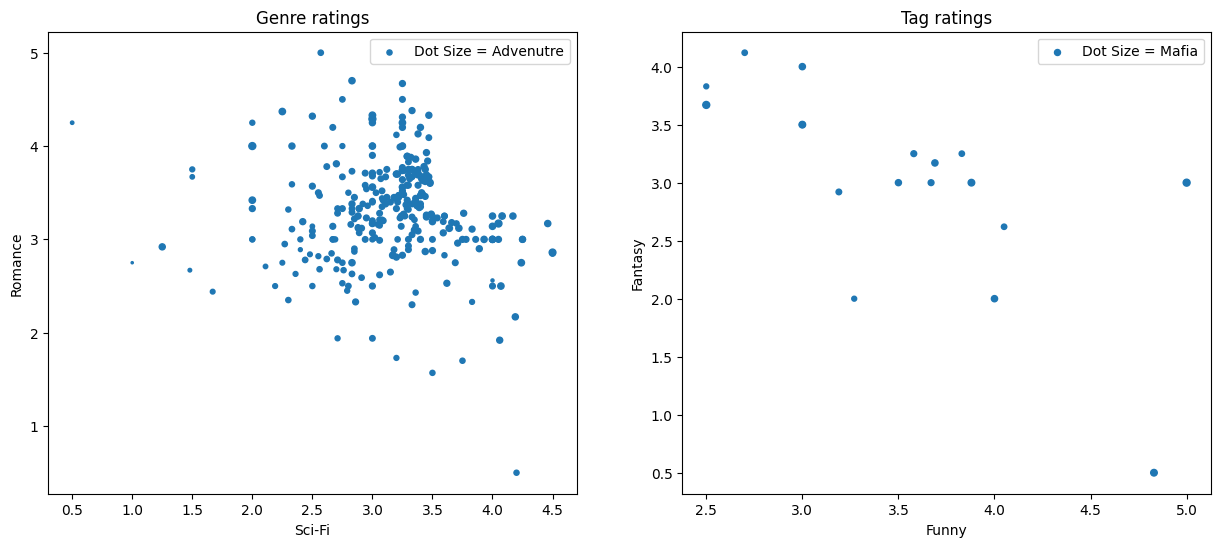

In [32]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.scatter(genre_ratings_biased['Sci-Fi'],genre_ratings_biased['Romance'], s=genre_ratings_biased['Adventure']*5, label='Dot Size = Advenutre')
ax.set_xlabel('Sci-Fi')
ax.set_ylabel('Romance')
ax.set_title('Genre ratings')
ax.legend()

ax = fig.add_subplot(122)
ax.scatter(tag_ratings_biased['funny'], tag_ratings_biased['fantasy'], s=tag_ratings_biased['mafia']*5, label = 'Dot Size = Mafia')
ax.set_xlabel('Funny')
ax.set_ylabel('Fantasy')
ax.set_title('Tag ratings')
ax.legend()


Training and test set separiation

In [33]:
#divide the data into training and test set by 80% and 20% respectively

movies_train = genre_ratings_biased.sample(frac=0.8, random_state=0)
movies_test = genre_ratings_biased.drop(movies_train.index)

tags_train = tag_ratings_biased.sample(frac=0.8, random_state=0)
tags_test = tag_ratings_biased.drop(tags_train.index)

Clustering

In [34]:
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans, AffinityPropagation , MeanShift, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


clustering_methods = [KMeans, Birch, MiniBatchKMeans, AffinityPropagation , 
                      MeanShift, SpectralClustering, AgglomerativeClustering] 

In [35]:
#create a function to plot the clusters in 3d and 2d with input the vector of predicted clusters for genres and tags respectively

def plot_clusters_3d_2d(X, Y, predictions, genre_k, tag_k):
    
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X['Sci-Fi'],X['Romance'],X['Adventure'], c=predictions[0].labels_, cmap='tab10')
    ax.set_xlabel('Sci-Fi')
    ax.set_ylabel('Romance')
    ax.set_zlabel('Adventure')
    ax.set_title('Clusters by favourite genres with K = ' + str(genre_k))

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(Y['funny'], Y['fantasy'], Y['mafia'], c=predictions[1].labels_, cmap='tab10')
    ax.set_xlabel('Funny')
    ax.set_ylabel('Fantasy')
    ax.set_zlabel('Mafia')
    ax.set_title('Clusters by favourite tags with K = ' + str(tag_k))

    plt.show()

    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121)
    ax.scatter(X['Sci-Fi'],X['Romance'],c=predictions[0].labels_, cmap='tab10', s=X['Adventure']**3)
    ax.set_xlabel('Sci-Fi')
    ax.set_ylabel('Romance')
    ax.set_title('Genre clustering, K = ' + str(genre_k) + ' (size = Adventure)')

    ax = fig.add_subplot(122)
    ax.scatter(Y['funny'], Y['fantasy'], c=predictions[1].labels_, cmap='tab10', s=Y['mafia']**3)
    ax.set_xlabel('Funny')
    ax.set_ylabel('Fantasy')
    ax.set_title('Tag clustering, K = ' + str(tag_k) + ' (size = Mafia)')

    plt.show()

In [36]:
def Cluster_data(data, n_clusters, cluster_function):
    X = data.copy()
    X = X.drop('userId', axis=1)
    if(cluster_function in [MeanShift, AffinityPropagation, SpectralClustering]):
        cluster = cluster_function()
    else:
        cluster = cluster_function(n_clusters=n_clusters)
    predictions = cluster.fit_predict(X)
    return cluster

In [39]:
#function to plot silhouette score for different number of clusters and different clustering methods
def silhouette_score_plot(data, method, title):
    trials = 1

    mean_genre_score = []
    for trial in range(trials):
        genre_score = []
        for i in range(2, 10):
            X = data[0].copy()
            X = X.drop('userId', axis=1)
            model = method(n_clusters=i)
            labels = model.fit_predict(X)
            genre_score.append(silhouette_score(X, labels))
        mean_genre_score.append(genre_score)

    mean_genre_score = np.mean(mean_genre_score, axis=0)    

    best_genre_K = np.argmax(mean_genre_score) + 2
    if best_genre_K == 2:
        best_genre_K = 3

    mean_tag_score = []
    for trial in range(trials):
        tag_score = []    
        for i in range(2, 10):
            X = data[1].copy()
            X = X.drop('userId', axis=1)
            model = method(n_clusters=i)
            labels = model.fit_predict(X)
            #compute silhouette score for tags
            tag_score.append(silhouette_score(X, labels))
        mean_tag_score.append(tag_score)

    mean_tag_score = np.mean(mean_tag_score, axis=0)     

    best_tag_K = np.argmax(mean_tag_score) + 2
    if best_tag_K == 2:
        best_tag_K = 3

    #plot silhouette score
    _ , ax = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

    ax[0].plot(range(2, 10), mean_genre_score)
    ax[0].set_title('Silhouette score for genres')
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Silhouette score')
    ax[0].grid()
    ax[1].plot(range(2, 10), mean_tag_score)
    ax[1].set_title('Silhouette score for tags')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette score')
    ax[1].grid()
    plt.suptitle(title)
    plt.show()

    return best_genre_K, best_tag_K

KMeans Clustering algorithm                                                            

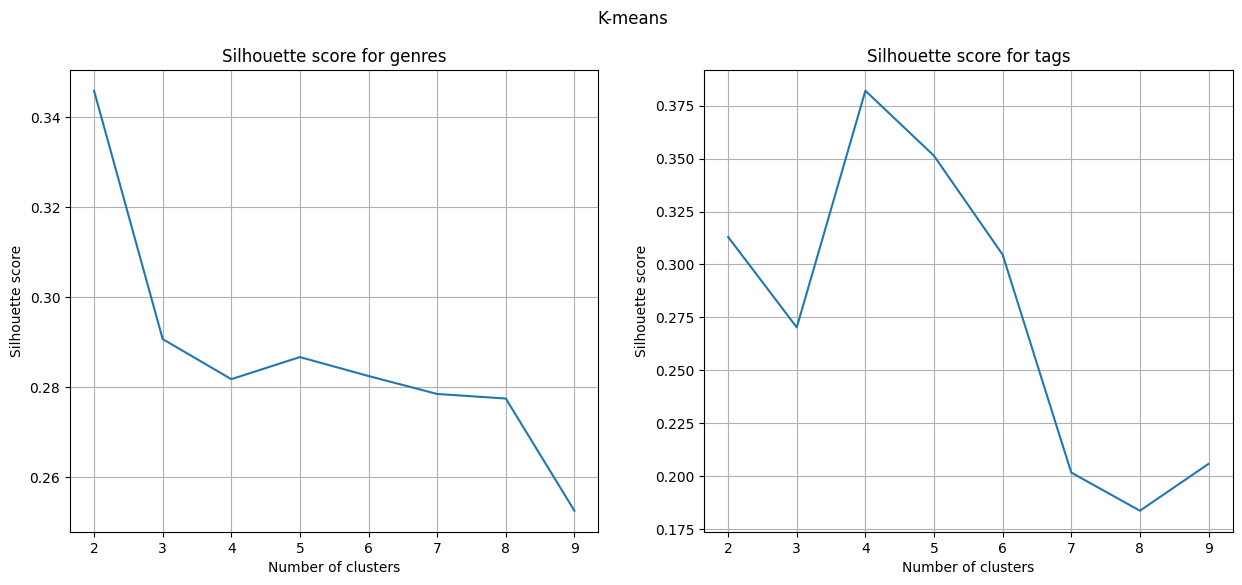

In [40]:
#optimization of K for KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], KMeans,'K-means')

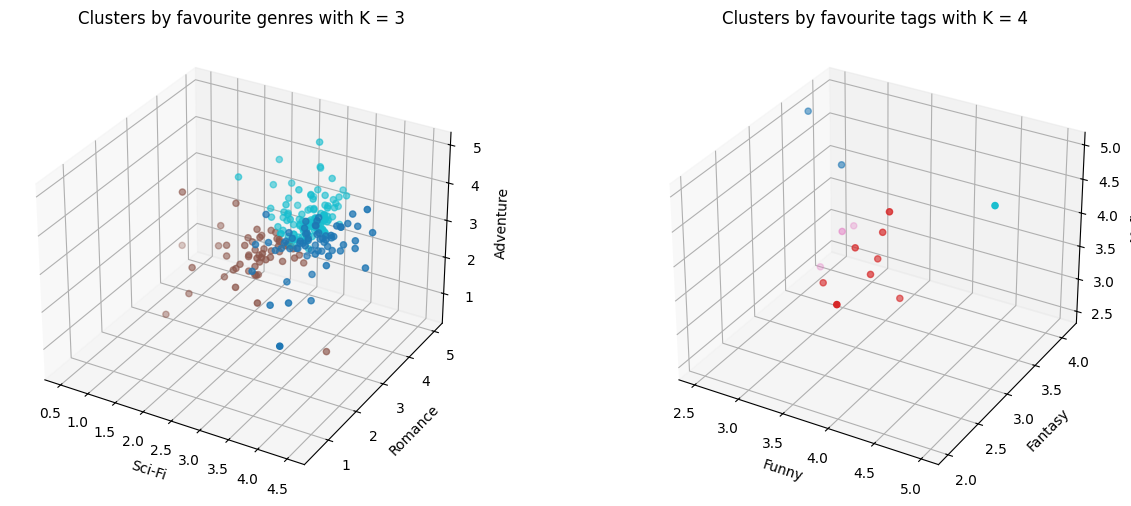

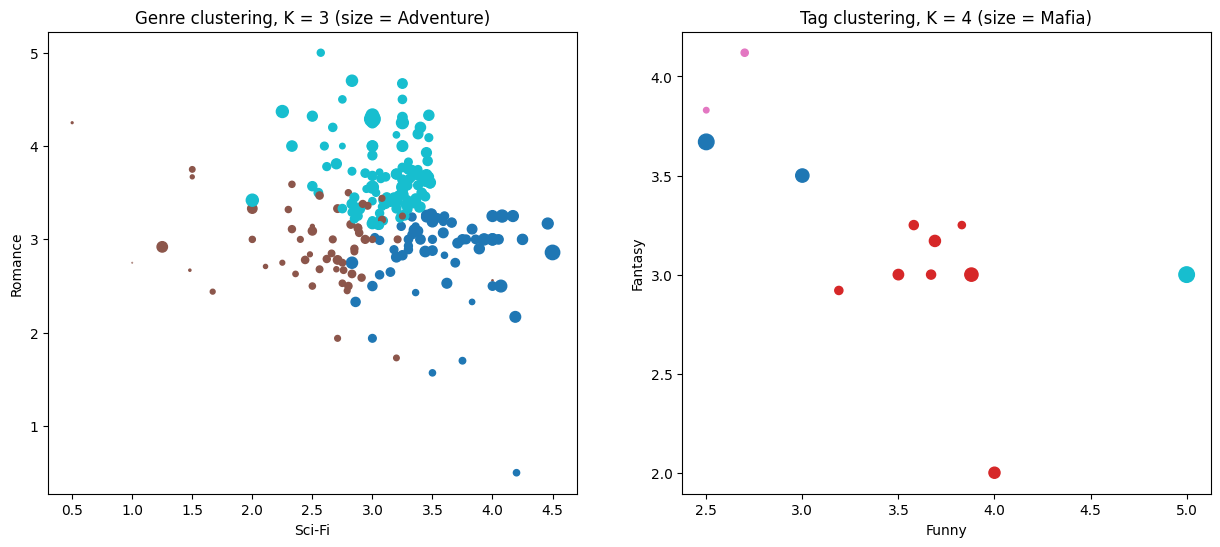

In [41]:
#Apply KMeans clustering by favourite genres and tags with K found before
genre_model_kmean = Cluster_data(movies_train, genre_k, KMeans)

tag_model_kmean = Cluster_data(tags_train, tag_K, KMeans)

#plot the clusters
plot_clusters_3d_2d(movies_train, tags_train, [genre_model_kmean,tag_model_kmean], genre_k, tag_K)


Birch Clustering Algorithm

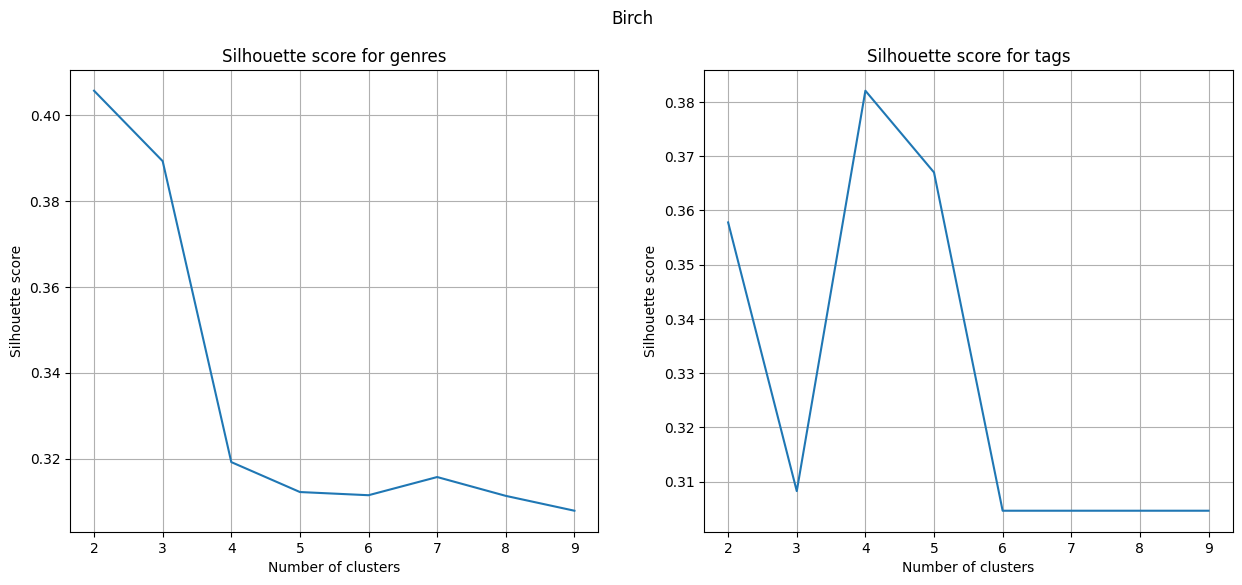

In [42]:
#optimization of K for Birch clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], Birch,'Birch')

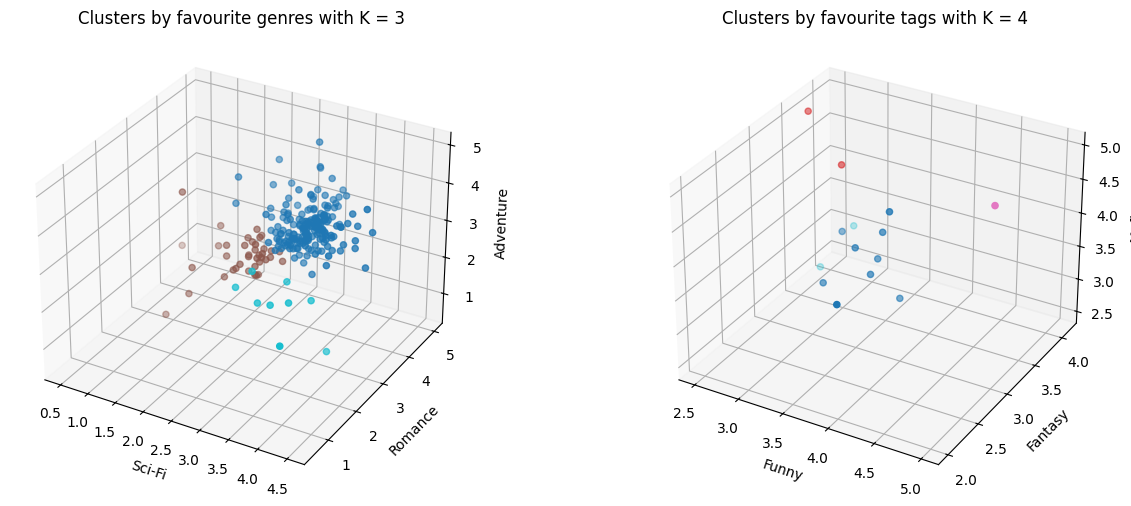

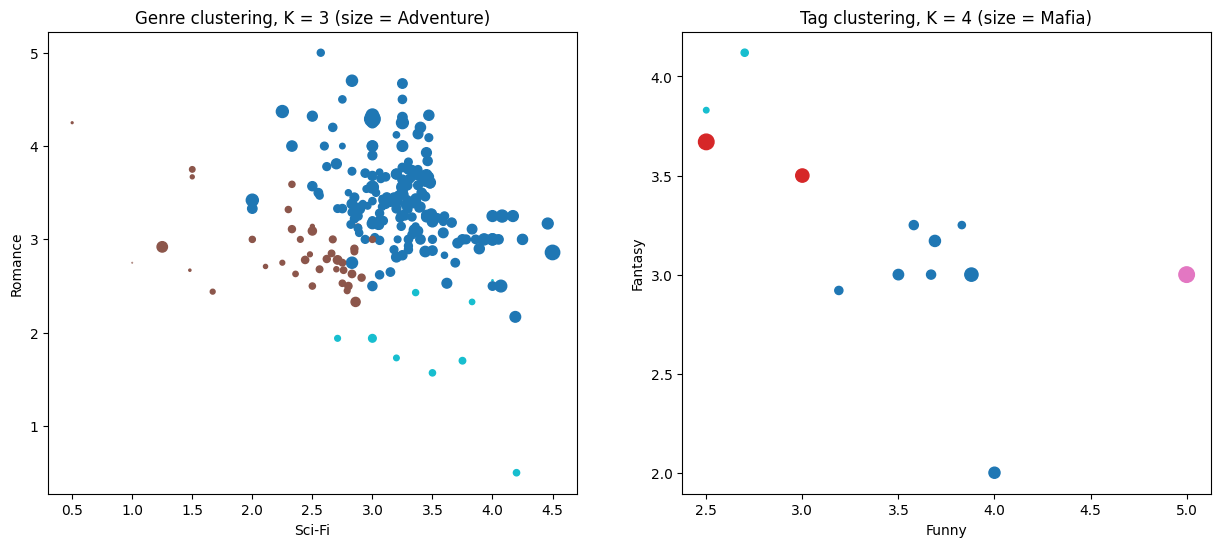

In [43]:
#implementation of Birch clustering by favourite genres
genre_model_birch = Cluster_data(movies_train, genre_k, Birch)

#implementation of Birch clustering by favourite tag
tag_model_birch = Cluster_data(tags_train, tag_K, Birch)


#plot the clusters
plot_clusters_3d_2d(movies_train, tags_train, [genre_model_birch,tag_model_birch],genre_k, tag_K)

Mini-Batch K-Means Clustering

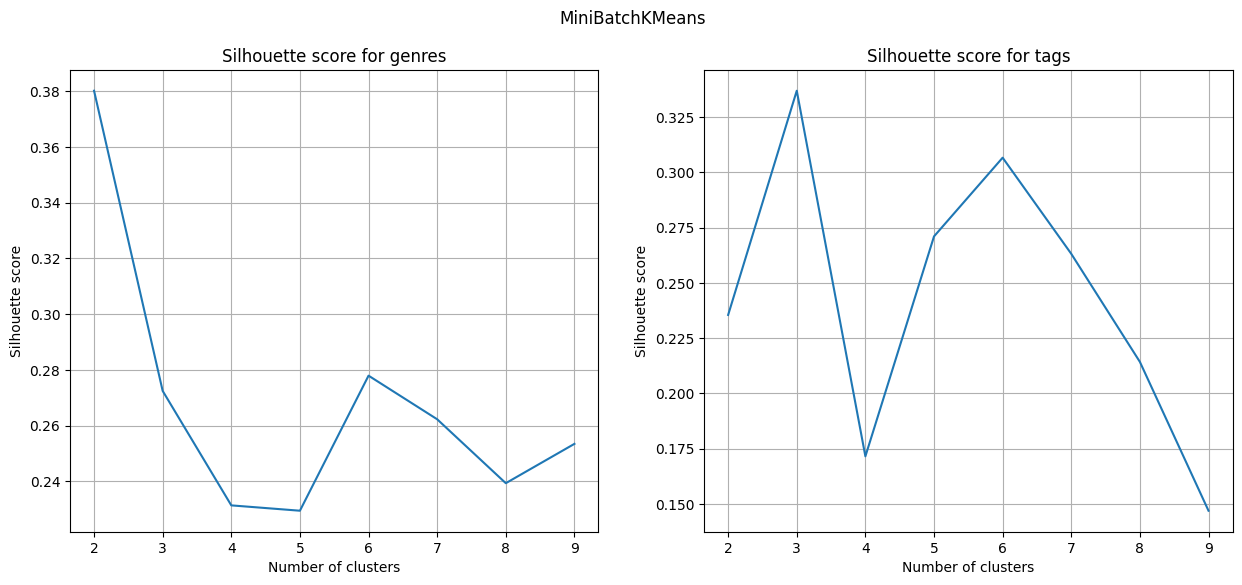

In [44]:
#optimization of K for Minibatch KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], MiniBatchKMeans,'MiniBatchKMeans')

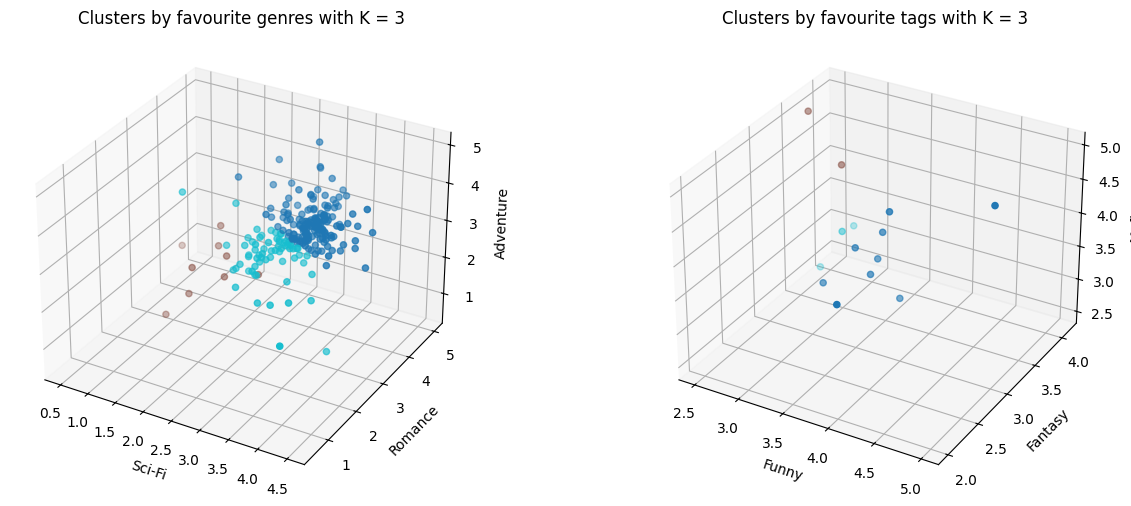

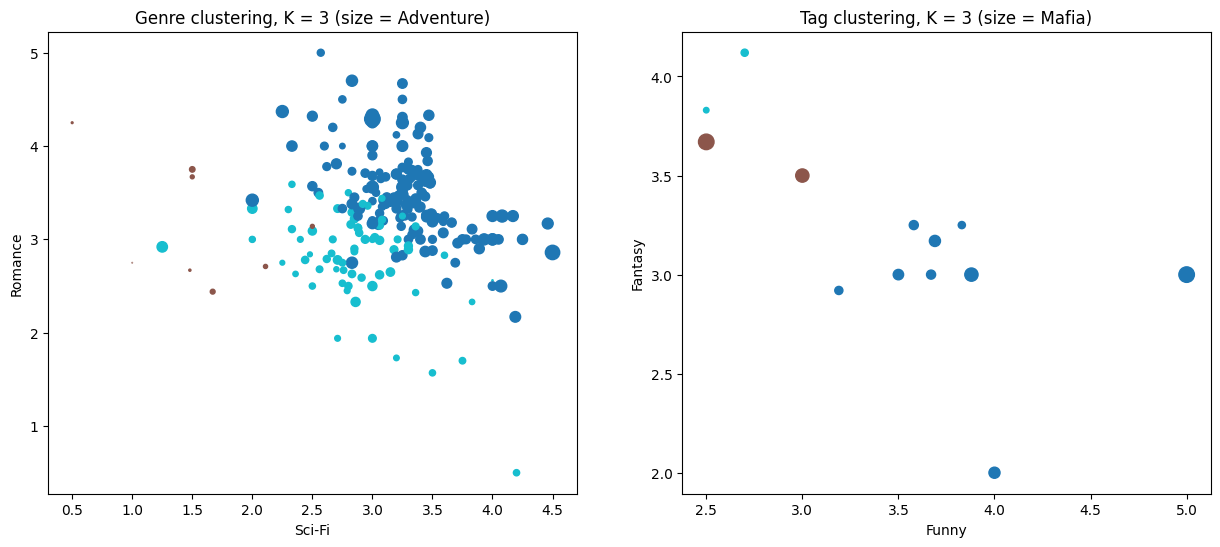

In [45]:
#implementation of MiniBatchKMeans clustering by favourite genres
genre_model_minibatcheskmeans = Cluster_data(movies_train, genre_k, MiniBatchKMeans)

#implementation of MiniBatchKMeans clustering by favourite tags
tag_model_minibatcheskmeans = Cluster_data(tags_train, tag_K, MiniBatchKMeans)

#plot the clusters
plot_clusters_3d_2d(movies_train, tags_train, [genre_model_minibatcheskmeans,tag_model_minibatcheskmeans],genre_k, tag_K)

Mean-Shift Clustering

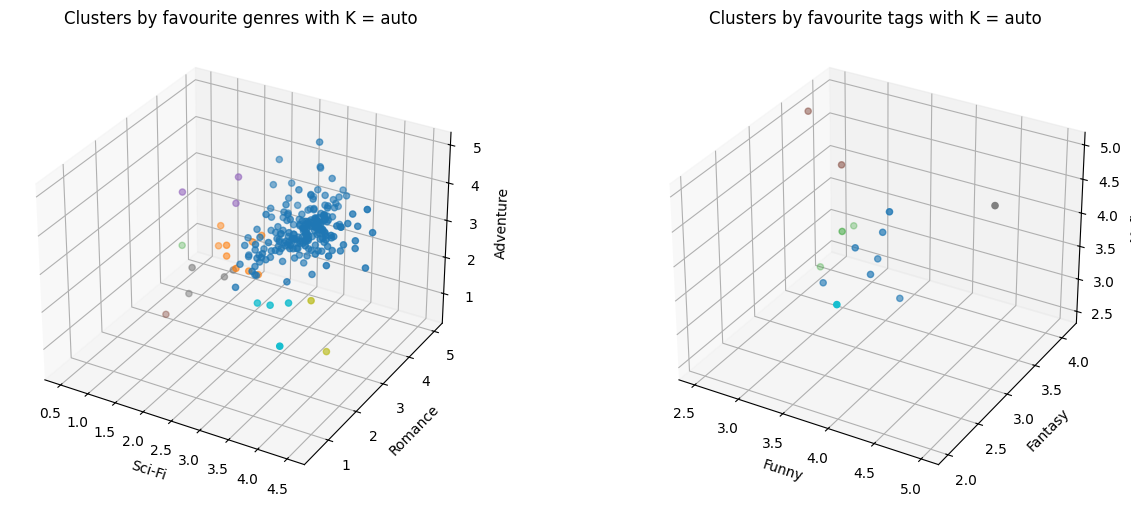

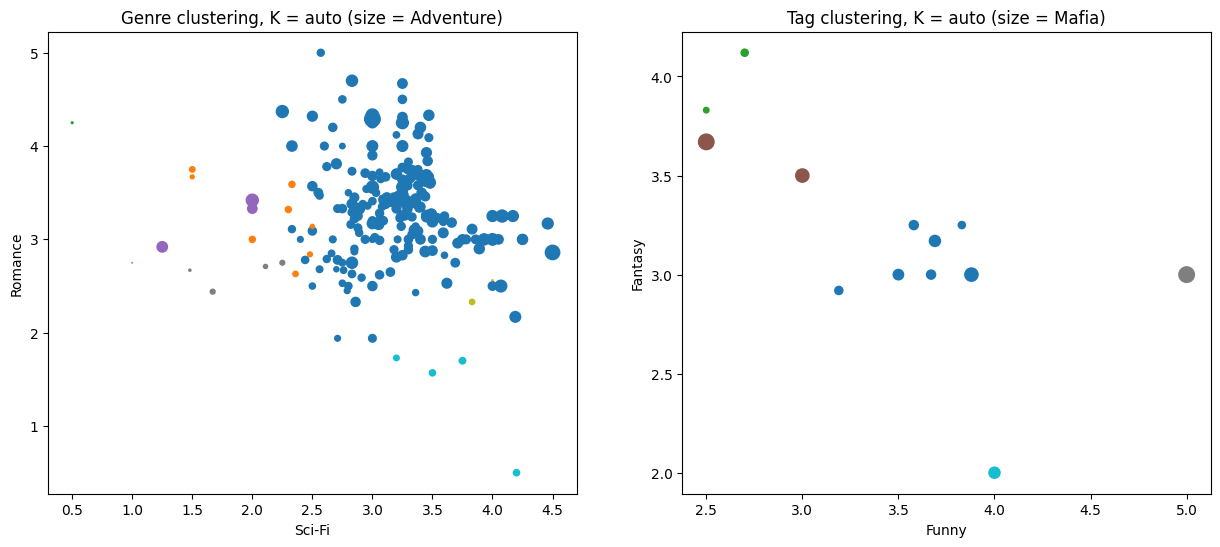

In [46]:
#implementation of MeanShift clustering by favourite genres
genre_model_meanshift = Cluster_data(movies_train, 3, MeanShift)

#implementation of MeanShift clustering by favourite tags
tag_model_meanshift = Cluster_data(tags_train, 3, MeanShift)

#plot the clusters
plot_clusters_3d_2d(movies_train, tags_train, [genre_model_meanshift,tag_model_meanshift], 'auto' , 'auto')

Affinity Propagation Clustering

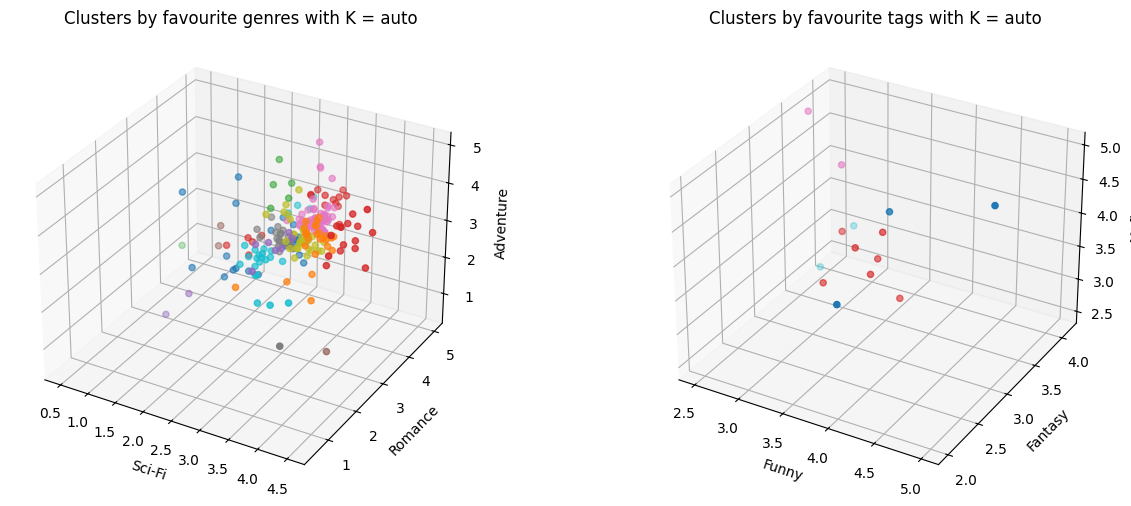

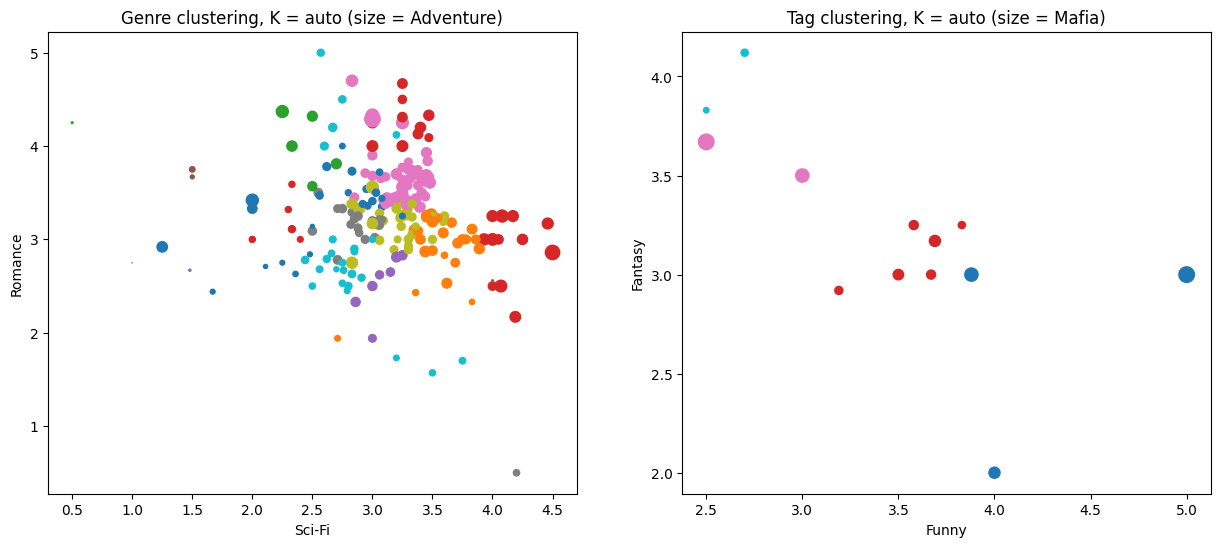

In [47]:
#implementation of AffinityPropagation clustering by favourite genres
genre_model_affinity = Cluster_data(movies_train, 3, AffinityPropagation)

#implementation of AffinityPropagation clustering by favourite tags
tag_model_affinity = Cluster_data(tags_train, 7, AffinityPropagation)

#plot the clusters
plot_clusters_3d_2d(movies_train, tags_train, [genre_model_affinity,tag_model_affinity], 'auto' , 'auto')

Agglomerative Clustering

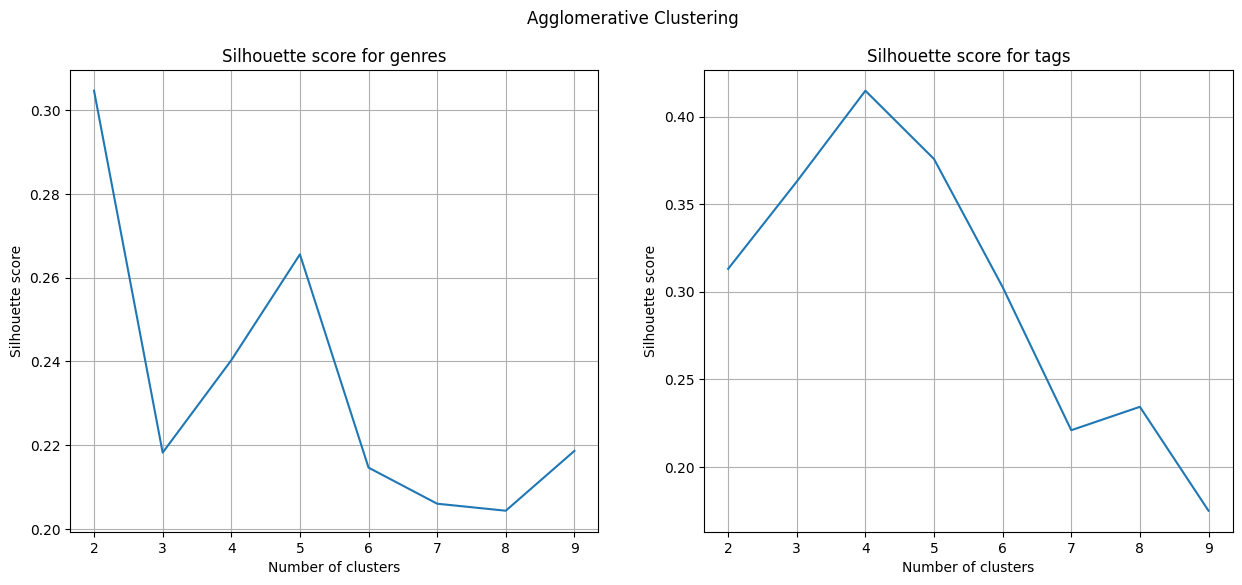

In [48]:
#optimization of K for Agglomerative KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], AgglomerativeClustering,'Agglomerative Clustering')

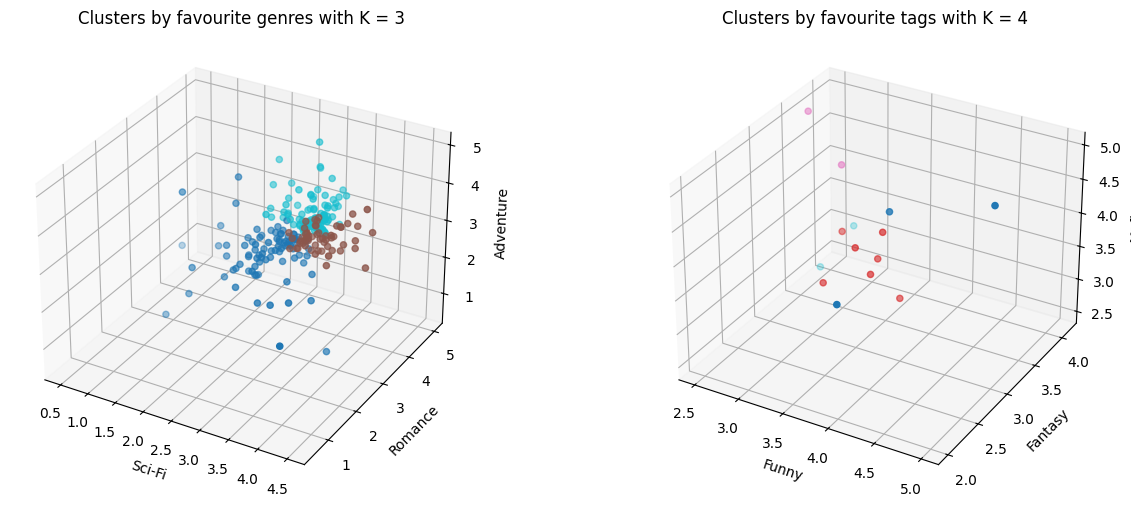

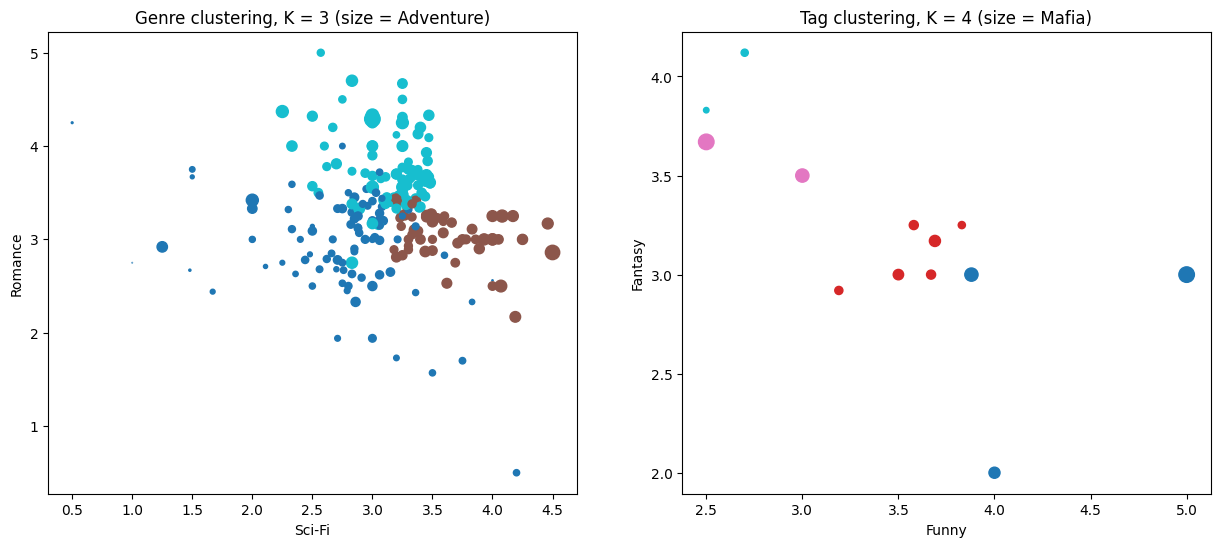

In [49]:
#implementation of AgglomerativeClustering clustering by favourite genres
genre_model_agglomerative = Cluster_data(movies_train, genre_k, AgglomerativeClustering)

#implementation of AgglomerativeClustering clustering by favourite tags
tag_model_agglomerative = Cluster_data(tags_train, tag_K, AgglomerativeClustering)

#plot the clusters
plot_clusters_3d_2d(movies_train, tags_train, [genre_model_agglomerative,tag_model_agglomerative], genre_k, tag_K)

Spectral Clustering

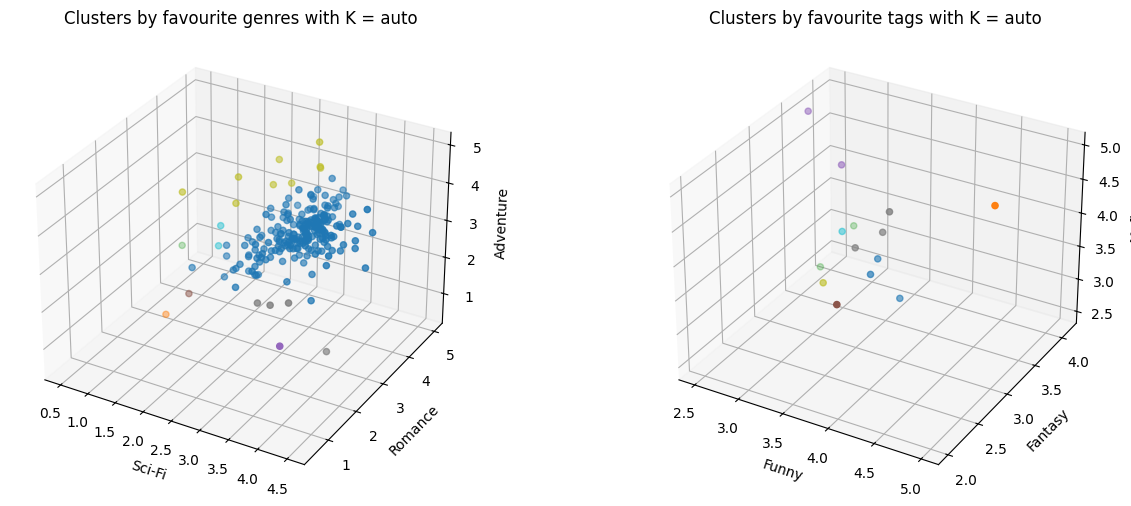

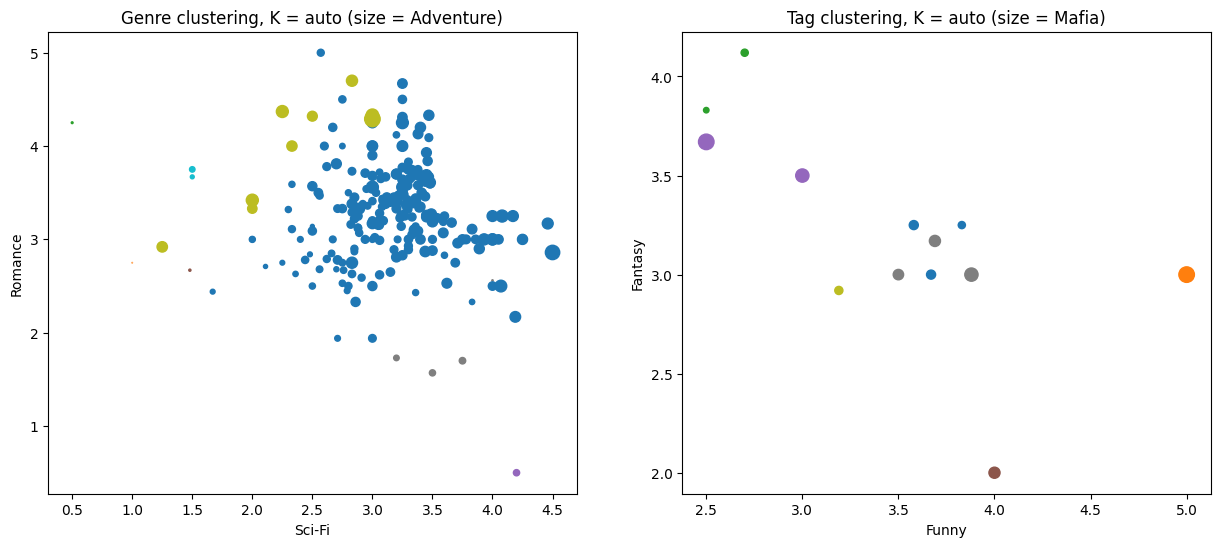

In [50]:
#implementation of SpectralClustering clustering by favourite genres
genre_model_spectral = Cluster_data(movies_train, 3, SpectralClustering)

#implementation of SpectralClustering clustering by favourite tags
tag_model_spectral  = Cluster_data(tags_train, 3, SpectralClustering)

#plot the clusters
plot_clusters_3d_2d(movies_train, tags_train, [genre_model_spectral,tag_model_spectral], 'auto', 'auto')

From this point on I will use the full 20M datapoints Movielens dataset to perform validation and evaluation of models since it is much more informative than the small dataset used for data visualization purposes only.

In [51]:
movies = pd.read_csv('ml-20m/movies.csv')

ratings = pd.read_csv('ml-20m/ratings.csv')

tags = pd.read_csv('ml-20m/tags.csv')

Data inspection and manipulation

In [52]:
ratings = ratings.drop('timestamp' , axis=1)
tags = tags.drop('timestamp', axis=1)
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  20000263  ratings of  27278  movies.


Creation of datapoints for clustering

In [53]:
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi', 'Adventure'], ['userId', 'Romance', 'Sci-Fi', 'Adventure'])
genre_ratings = genre_ratings.dropna()

tags = tags.dropna()
tag_ratings = get_tag_ratings(ratings, tags, ['funny', 'fantasy', 'mafia'], ['userId', 'funny', 'fantasy', 'mafia'])
tag_ratings = tag_ratings.dropna()

In [54]:
genre_ratings_biased = bias_genre_rating_dataset(genre_ratings, 3.0, 2.5)
genre_ratings_biased = genre_ratings_biased.reset_index(drop=True)
print( "Number of users for genres: ", len(genre_ratings_biased))

tag_ratings_biased = bias_tag_rating_dataset(tag_ratings, 3.0, 2.5)
tag_ratings_biased = tag_ratings_biased.reset_index(drop=True)
print( "Number of users for tags: ", len(tag_ratings_biased))

Number of users for genres:  25236
Number of users for tags:  8370


In [55]:
#train and test split
movies_train = genre_ratings_biased.sample(frac=0.8, random_state=0)
movies_test = genre_ratings_biased.drop(movies_train.index)

tags_train = tag_ratings_biased.sample(frac=0.8, random_state=0)
tags_test = tag_ratings_biased.drop(tags_train.index)

In [56]:
def Find_best_K(data, method):
    
    genre_score = []
    for i in range(3, 10, 2 ):
        model = Cluster_data(data[0], i, method)
        genre_score.append(silhouette_score(data[0].drop('userId' , axis=1), model.labels_))

    best_genre_K = np.argmax(genre_score) + 2
    if best_genre_K == 2:
        best_genre_K = 3


    tag_score = []    
    for i in range(3, 10, 2):
        model = Cluster_data(data[0], i, method)
        tag_score.append(silhouette_score(data[0].drop('userId' , axis=1), model.labels_))
        
    best_tag_K = np.argmax(tag_score) + 2
    if best_tag_K == 2:
        best_tag_K = 3

    return best_genre_K, best_tag_K

In [57]:
genre_K, tag_K = Find_best_K([movies_train,tags_train], KMeans)
genre_K, tag_K

(3, 3)

In [63]:
genre_model_kmean = Cluster_data(movies_train, genre_K, KMeans)
tag_model_kmean = Cluster_data(tags_train, tag_K, KMeans)
genre_model_birch = Cluster_data(movies_train, genre_K, Birch)
tag_model_birch = Cluster_data(tags_train, tag_K, Birch)
genre_model_minibatcheskmeans = Cluster_data(movies_train, genre_K, MiniBatchKMeans)
tag_model_minibatcheskmeans = Cluster_data(tags_train, tag_K, MiniBatchKMeans)
genre_model_meanshift = Cluster_data(movies_train, 3, MeanShift)
tag_model_meanshift = Cluster_data(tags_train, 3, MeanShift)
genre_model_affinity = Cluster_data(movies_train, 3, AffinityPropagation)
tag_model_affinity = Cluster_data(tags_train, 7, AffinityPropagation)
genre_model_agglomerative = Cluster_data(movies_train, genre_K, AgglomerativeClustering)
tag_model_agglomerative = Cluster_data(tags_train, tag_K, AgglomerativeClustering)
genre_model_spectral = Cluster_data(movies_train, 3, SpectralClustering)
tag_model_spectral = Cluster_data(tags_train, 3, SpectralClustering)

EVALUATION CRITERIA

In [58]:
# I used the mean of each cluster datapoints as centroids to have uniformity 
# between different models since some of them doesn't come with the centroids attribute 

def get_centroids(data, model):
    centroids = []
    predictions = model.labels_
    number_of_clusters = len(set(model.labels_))
    for i in range(number_of_clusters):
        cluster = data[predictions == i]
        cluster = cluster.drop('userId', axis=1)
        cluster = cluster.mean()
        centroids.append(cluster.values)            
    return centroids

In [59]:
# function to predic new data_points clusters for agglomerative 
# and spectral clustering which do not have a proper prediction method
def pseudo_predict_new_data(test_data, train_data, model):
    predictions = []
    for index, row in test_data.iterrows():
        min_distance = float('inf')
        cluster_id = -1
        for i in range(len(set(model.labels_))):
            distance = np.linalg.norm(row[1:] - get_centroids(train_data,model)[i])
            if distance < min_distance:
                min_distance = distance
                cluster_id = i
        predictions.append(model.labels_[cluster_id])
    return predictions

In [60]:
#Function to predict new data points from testset into existing models
def predict_new_data(test_data, model,train_data, model_name):
    X = test_data.copy()
    X = X.drop('userId', axis=1)
    if(model_name in['agglomerative', 'spectral']):
        predictions = pseudo_predict_new_data(test_data, train_data, model)
    else:
        predictions = model.predict(X)
    return predictions

MEAN SQUARED ERROR

In [61]:
#function to calculate MSE for different clustering models
def calculate_MSE(test_data, model,train_data, model_name):
    new_predictions = predict_new_data(test_data, model,train_data, model_name)
    #new_predictions = model.labels_
    MSE = 0
    centroids = get_centroids(train_data, model)
    test_data = test_data.reset_index()
    for index, row in test_data.iterrows():
        user = row.drop('userId')
        user = user.drop('index')
        user = user.values
        cluster_id = new_predictions[index]
        MSE += np.square(np.linalg.norm((user - centroids[cluster_id])))
    return MSE/len(test_data)


In [62]:
k = [2,3,4,5,6,7,8,9,10]
j = [2,3,4,5,6]
kmeans_mse_genre = []
birch_mse_genre = []
minibatcheskmeans_mse_genre = []
agglomerative_mse_genre = []
kmeans_mse_tag = []
birch_mse_tag = []
minibatcheskmeans_mse_tag = []
agglomerative_mse_tag = []
for i in k:
    kmeans_mse_genre.append(calculate_MSE(movies_test, Cluster_data(movies_train, i, KMeans), movies_train, 'kmeans'))
    birch_mse_genre.append(calculate_MSE(movies_test, Cluster_data(movies_train, i, Birch), movies_train, 'birch'))
    minibatcheskmeans_mse_genre.append(calculate_MSE(movies_test, Cluster_data(movies_train, i, MiniBatchKMeans), movies_train, 'minibatcheskmeans'))
    agglomerative_mse_genre.append(calculate_MSE(movies_test, Cluster_data(movies_train, i, AgglomerativeClustering), movies_train, 'agglomerative'))
for i in j:
    kmeans_mse_tag.append(calculate_MSE(tags_test, Cluster_data(tags_train, i, KMeans), tags_train, 'kmeans'))
    birch_mse_tag.append(calculate_MSE(tags_test, Cluster_data(tags_train, i, Birch), tags_train, 'birch'))
    minibatcheskmeans_mse_tag.append(calculate_MSE(tags_test, Cluster_data(tags_train, i, MiniBatchKMeans), tags_train, 'minibatcheskmeans'))
    agglomerative_mse_tag.append(calculate_MSE(tags_test, Cluster_data(tags_train, i, AgglomerativeClustering), tags_train, 'agglomerative'))

KeyboardInterrupt: 

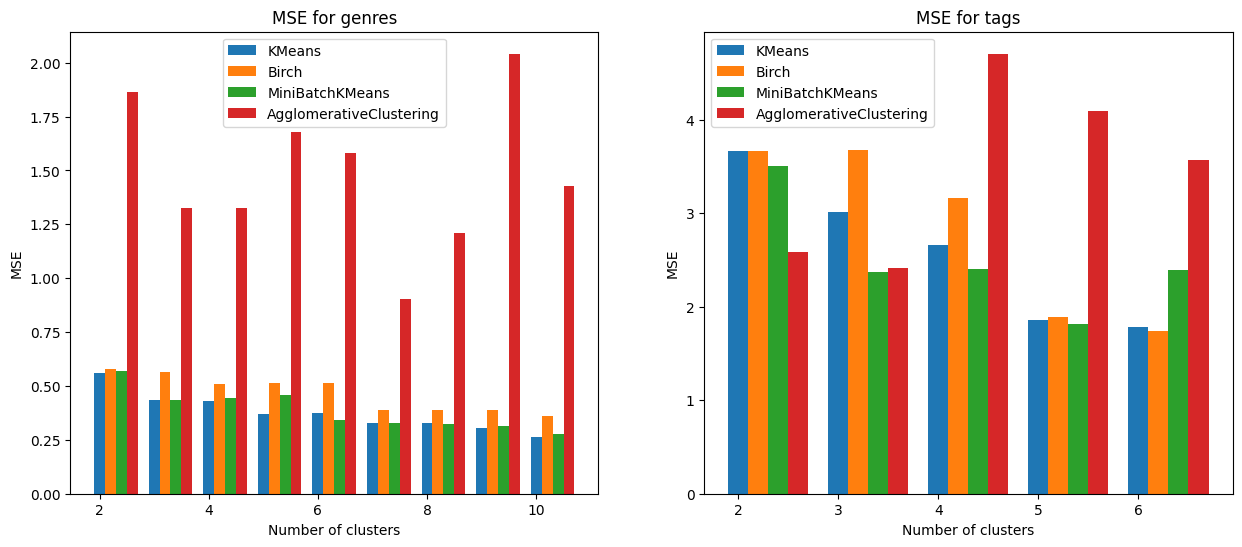

In [ ]:
#plot the MSE for different clustering models
k = np.array(k)
j = np.array(j)
width = 0.2
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.bar(k, kmeans_mse_genre, width=width, label='KMeans')
ax.bar(k+width, birch_mse_genre, width=width, label='Birch')
ax.bar(k+width*2, minibatcheskmeans_mse_genre, width=width, label='MiniBatchKMeans')
ax.bar(k+width*3, agglomerative_mse_genre, width=width, label='AgglomerativeClustering')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('MSE')
ax.set_title('MSE for genres')
ax.legend()

ax = fig.add_subplot(122)

ax.bar(j, kmeans_mse_tag, width=width, label='KMeans')
ax.bar(j+width, birch_mse_tag, width=width, label='Birch')
ax.bar(j+width*2, minibatcheskmeans_mse_tag, width=width, label='MiniBatchKMeans')
ax.bar(j+width*3, agglomerative_mse_tag, width=width, label='AgglomerativeClustering')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('MSE')
ax.set_title('MSE for tags')
ax.legend()

plt.show()


DUNN'S INDEX

In [ ]:
#a function to calculate the Dunn index for different existing clustering models
def calculate_Dunn_index(data, model):
    centroids = []
    predictions = model.labels_
    number_of_clusters = len(set(model.labels_))
    centroids = get_centroids(data, model)
    min_distance = float('inf')
    for i in range(number_of_clusters):
        for j in range(i+1, number_of_clusters):
            distance = np.linalg.norm(centroids[i] - centroids[j])
            if distance < min_distance:
                min_distance = distance
    max_distance = 0
    for i in range(number_of_clusters):
        for j in range(len(data)):
            if predictions[j] == i:
                distance = np.linalg.norm(data.iloc[j].drop('userId').values - centroids[i])
                if distance > max_distance:
                    max_distance = distance
    return min_distance/max_distance

In [ ]:
k = [2,3,4,5,6,7,8,9,10]
j = [2,3,4,5,6]
kmeans_dunn_genre = []
birch_dunn_genre = []
minibatcheskmeans_dunn_genre = []
agglomerative_dunn_genre = []
kmeans_dunn_tag = []
birch_dunn_tag = []
minibatcheskmeans_dunn_tag = []
agglomerative_dunn_tag = []
for i in k:
    kmeans_dunn_genre.append(calculate_Dunn_index(movies_train, Cluster_data(movies_train, i, KMeans)))
    birch_dunn_genre.append(calculate_Dunn_index(movies_train, Cluster_data(movies_train, i, Birch)))
    minibatcheskmeans_dunn_genre.append(calculate_Dunn_index(movies_train, Cluster_data(movies_train, i, MiniBatchKMeans)))
    agglomerative_dunn_genre.append(calculate_Dunn_index(movies_train, Cluster_data(movies_train, i, AgglomerativeClustering)))
for i in j:
    kmeans_dunn_tag.append(calculate_Dunn_index(tags_train, Cluster_data(tags_train, i, KMeans)))
    birch_dunn_tag.append(calculate_Dunn_index(tags_train, Cluster_data(tags_train, i, Birch)))
    minibatcheskmeans_dunn_tag.append(calculate_Dunn_index(tags_train, Cluster_data(tags_train, i, MiniBatchKMeans)))
    agglomerative_dunn_tag.append(calculate_Dunn_index(tags_train, Cluster_data(tags_train, i, AgglomerativeClustering)))

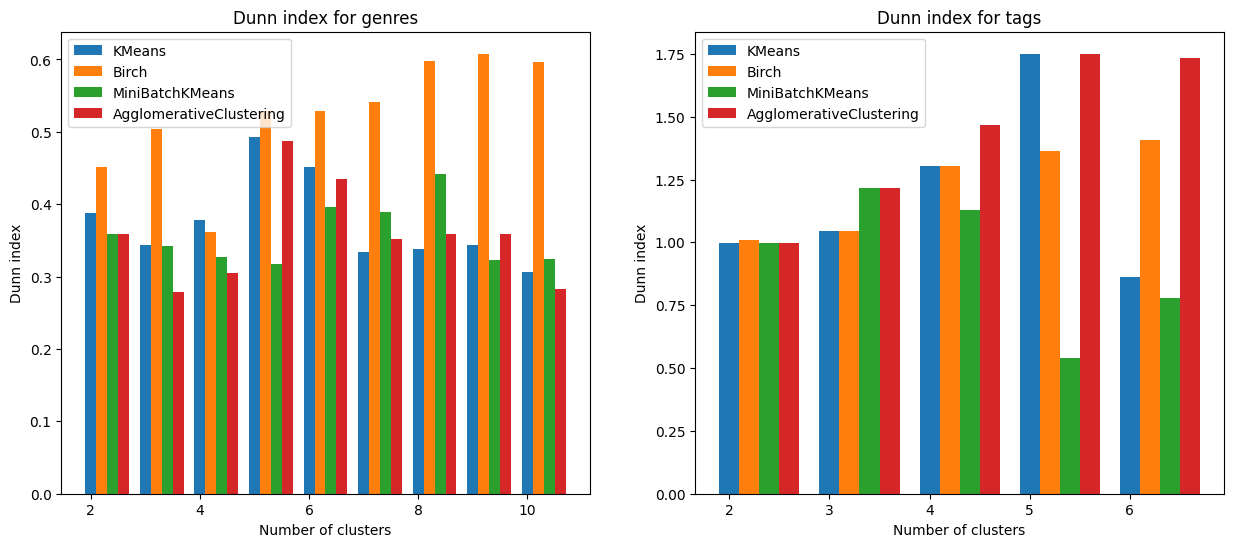

In [ ]:
#plot the Dunn index for different clustering models
k = np.array(k)
j = np.array(j)
width = 0.2
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.bar(k, kmeans_dunn_genre, width=width, label='KMeans')
ax.bar(k+width, birch_dunn_genre, width=width, label='Birch')
ax.bar(k+width*2, minibatcheskmeans_dunn_genre, width=width, label='MiniBatchKMeans')
ax.bar(k+width*3, agglomerative_dunn_genre, width=width, label='AgglomerativeClustering')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Dunn index')
ax.set_title('Dunn index for genres')
ax.legend()

ax = fig.add_subplot(122)
ax.bar(j, kmeans_dunn_tag, width=width, label='KMeans')
ax.bar(j+width, birch_dunn_tag, width=width, label='Birch')
ax.bar(j+width*2, minibatcheskmeans_dunn_tag, width=width, label='MiniBatchKMeans')
ax.bar(j+width*3, agglomerative_dunn_tag, width=width, label='AgglomerativeClustering')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Dunn index')
ax.set_title('Dunn index for tags')
ax.legend()

plt.show()

AVARAGE SIMILARITY

In [ ]:
def cosine_similarity(v1, v2):
  v1_norm = np.linalg.norm(v1)
  v2_norm = np.linalg.norm(v2)
  if v1_norm * v2_norm == 0:
    return 0
  return np.dot(v1, v2) / (v1_norm * v2_norm)


In [ ]:
def average_similarity_between_clusters(data, cluster_labels, cluster1, cluster2):

  cluster1_data = data[cluster_labels == cluster1]
  cluster2_data = data[cluster_labels == cluster2]


  similarities = []
  for data1 in cluster1_data:
    for data2 in cluster2_data:
      similarities.append(cosine_similarity(data1, data2))

  if not similarities:
    return 0

  return np.mean(similarities)


In [ ]:
 #compute the average similarity between clusters for every pair of clusters and then avarage them
def average_similarity(data, model):
  cluster_similarities = []
  labels = model.labels_
  for cluster1 in range(len(set(labels))):
    for cluster2 in range(cluster1+1, len(set(labels))):
      if cluster1 != cluster2:
        cluster_similarities.append(average_similarity_between_clusters(data, labels, cluster1, cluster2))
  return np.mean(cluster_similarities)

In [ ]:
k = [3,6,9]
kmeans_similarity_genre = []
birch_similarity_genre = []
minibatcheskmeans_similarity_genre = []
agglomerative_similarity_genre = []
kmeans_similarity_tag = []
birch_similarity_tag = []
minibatcheskmeans_similarity_tag = []
agglomerative_similarity_tag = []
for i in k:
    kmeans_similarity_genre.append(average_similarity(movies_train.drop('userId', axis=1).values, Cluster_data(movies_train, i, KMeans)))
    birch_similarity_genre.append(average_similarity(movies_train.drop('userId', axis=1).values, Cluster_data(movies_train, i, Birch)))
    minibatcheskmeans_similarity_genre.append(average_similarity(movies_train.drop('userId', axis=1).values, Cluster_data(movies_train, i, MiniBatchKMeans)))
    agglomerative_similarity_genre.append(average_similarity(movies_train.drop('userId', axis=1).values, Cluster_data(movies_train, i, AgglomerativeClustering)))
    kmeans_similarity_tag.append(average_similarity(tags_train.drop('userId', axis=1).values, Cluster_data(tags_train, i, KMeans)))
    birch_similarity_tag.append(average_similarity(tags_train.drop('userId', axis=1).values, Cluster_data(tags_train, i, Birch)))
    minibatcheskmeans_similarity_tag.append(average_similarity(tags_train.drop('userId', axis=1).values, Cluster_data(tags_train, i, MiniBatchKMeans)))
    agglomerative_similarity_tag.append(average_similarity(tags_train.drop('userId', axis=1).values, Cluster_data(tags_train, i, AgglomerativeClustering)))

In [ ]:
#print a fancy table to show the results of the similarity for different clustering models and number of clusters
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "K=3", "K=6", "K=9"]
table.add_row(["KMeans (Genres)", kmeans_similarity_genre[0], kmeans_similarity_genre[1], kmeans_similarity_genre[2]])
table.add_row(["Birch (Genres)", birch_similarity_genre[0], birch_similarity_genre[1], birch_similarity_genre[2]])
table.add_row(["MiniBatchKMeans (Genres)", minibatcheskmeans_similarity_genre[0], minibatcheskmeans_similarity_genre[1], minibatcheskmeans_similarity_genre[2]])
table.add_row(["AgglomerativeClustering (Genres)", agglomerative_similarity_genre[0], agglomerative_similarity_genre[1], agglomerative_similarity_genre[2]])
table.add_row(["KMeans (Tags)", kmeans_similarity_tag[0], kmeans_similarity_tag[1], kmeans_similarity_tag[2]])
table.add_row(["Birch (Tags)", birch_similarity_tag[0], birch_similarity_tag[1], birch_similarity_tag[2]])
table.add_row(["MiniBatchKMeans (Tags)", minibatcheskmeans_similarity_tag[0], minibatcheskmeans_similarity_tag[1], minibatcheskmeans_similarity_tag[2]])
table.add_row(["AgglomerativeClustering (Tags)", agglomerative_similarity_tag[0], agglomerative_similarity_tag[1], agglomerative_similarity_tag[2]])
print(table)





+----------------------------------+--------------------+--------------------+--------------------+
|              Model               |        K=3         |        K=6         |        K=9         |
+----------------------------------+--------------------+--------------------+--------------------+
|         KMeans (Genres)          | 0.971994654430023  | 0.9331528010054461 | 0.9354446739839877 |
|          Birch (Genres)          | 0.9430315311351182 | 0.8910602108510092 | 0.8735161418333675 |
|     MiniBatchKMeans (Genres)     | 0.9747480340725015 | 0.9687640405747078 | 0.9079232216418279 |
| AgglomerativeClustering (Genres) | 0.9806750263454699 | 0.9307667640288773 | 0.9442371010892651 |
|          KMeans (Tags)           | 0.967280076454981  | 0.963851919122375  | 0.9645012996208392 |
|           Birch (Tags)           | 0.9516139880476975 | 0.963851919122375  | 0.963851919122375  |
|      MiniBatchKMeans (Tags)      | 0.9646548009499045 | 0.963851919122375  | 0.9712624373200642 |


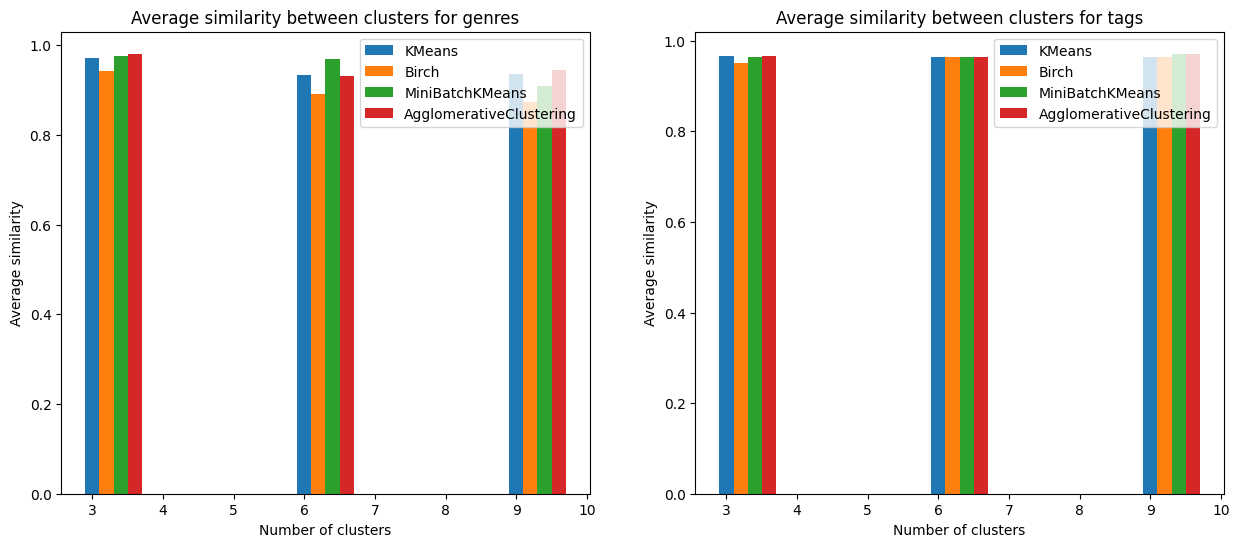

In [ ]:
#plot the average similarity between clusters for different clustering models
k = np.array(k)
j = np.array(j)
width = 0.2
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.bar(k, kmeans_similarity_genre, width=width, label='KMeans')
ax.bar(k+width, birch_similarity_genre, width=width, label='Birch')
ax.bar(k+width*2, minibatcheskmeans_similarity_genre, width=width, label='MiniBatchKMeans')
ax.bar(k+width*3, agglomerative_similarity_genre, width=width, label='AgglomerativeClustering')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Average similarity')
ax.set_title('Average similarity between clusters for genres')
ax.legend()

ax = fig.add_subplot(122)
ax.bar(k, kmeans_similarity_tag, width=width, label='KMeans')
ax.bar(k+width, birch_similarity_tag, width=width, label='Birch')
ax.bar(k+width*2, minibatcheskmeans_similarity_tag, width=width, label='MiniBatchKMeans')
ax.bar(k+width*3, agglomerative_similarity_tag, width=width, label='AgglomerativeClustering')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Average similarity')
ax.set_title('Average similarity between clusters for tags')
ax.legend()

plt.show()

COMPUTATIONAL TIME

In [ ]:
from tabulate import tabulate
def evaluate_models(data, clustering_methods):
    results = []
    for method in clustering_methods:
        start = time.time()
        Cluster_data(data, 3, method)
        end = time.time()
        results.append([method.__name__, (end-start)*1000])
    return results

genre_results = evaluate_models(movies_train, clustering_methods)

headers = ["Algorithm", "Execution Time (ms)"]
table = tabulate(genre_results, headers=headers, tablefmt="fancy_grid")
title = "Genre Clustering Evaluation"
print(title + "\n" + table)


Genre Clustering Evaluation
╒═════════════════════════╤═══════════════════════╕
│ Algorithm               │   Execution Time (ms) │
╞═════════════════════════╪═══════════════════════╡
│ KMeans                  │               7.66945 │
├─────────────────────────┼───────────────────────┤
│ Birch                   │               7.77388 │
├─────────────────────────┼───────────────────────┤
│ MiniBatchKMeans         │               8.74066 │
├─────────────────────────┼───────────────────────┤
│ AffinityPropagation     │              29.4411  │
├─────────────────────────┼───────────────────────┤
│ MeanShift               │             568.86    │
├─────────────────────────┼───────────────────────┤
│ SpectralClustering      │              34.8482  │
├─────────────────────────┼───────────────────────┤
│ AgglomerativeClustering │               3.69692 │
╘═════════════════════════╧═══════════════════════╛


In [ ]:
tag_results = evaluate_models(tags_train, clustering_methods)
table = tabulate(tag_results, headers=headers, tablefmt="fancy_grid")
title = "Tag Clustering Evaluation"
print(title + "\n" + table)

Tag Clustering Evaluation
╒═════════════════════════╤═══════════════════════╕
│ Algorithm               │   Execution Time (ms) │
╞═════════════════════════╪═══════════════════════╡
│ KMeans                  │              10.2682  │
├─────────────────────────┼───────────────────────┤
│ Birch                   │               3.17931 │
├─────────────────────────┼───────────────────────┤
│ MiniBatchKMeans         │              61.1176  │
├─────────────────────────┼───────────────────────┤
│ AffinityPropagation     │               5.72205 │
├─────────────────────────┼───────────────────────┤
│ MeanShift               │              24.2388  │
├─────────────────────────┼───────────────────────┤
│ SpectralClustering      │              20.4141  │
├─────────────────────────┼───────────────────────┤
│ AgglomerativeClustering │               2.52318 │
╘═════════════════════════╧═══════════════════════╛


OTHER CRITERIA!!!!!!!!!!!!!!!!!!!!

scelgo numero di k per avere top_n_movies!!!!!!!
printo userId del test set da testare per le recommendations

In [ ]:
#Function that returns the top N recommended movies for a given user 
def TOP_N_MOVIES_GENRE(model,user_id,N):
    if(user_id in movies_test['userId'].values):
        X = movies_test.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = predict_new_data(movies_test, model, movies_train)[new_user]
        cluster_ids = movies_train[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == movies_test.iloc[new_user]['userId']]
    elif(user_id in movies_train['userId'].values):
        X = movies_train.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = model.labels_[new_user]
        cluster_ids = movies_train[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == movies_train.iloc[new_user]['userId']]
    else:
        print('User not found')
        return
    cluster_movies_not_rated = ratings[ratings['userId'].isin(cluster_ids) & ~ratings['movieId'].isin(user_rated_movies['movieId'])].drop('userId', axis=1).groupby('movieId').mean().sort_values('rating', ascending=False).head(N)
    for(index, _) in cluster_movies_not_rated.iterrows():
        cluster_movies_not_rated.at[index, 'title'] = movies[movies['movieId'] == index]['title'].values[0]
    return cluster_movies_not_rated.drop('rating', axis=1)

TOP_N_MOVIES_GENRE(genre_model_birch, 609, 20)

,title
movieId,
42946,Project A ('A' gai waak) (1983)
271,Losing Isaiah (1995)
3813,Interiors (1978)
84273,Zeitgeist: Moving Forward (2011)
484,Lassie (1994)
2069,"Trip to Bountiful, The (1985)"
6650,Kind Hearts and Coronets (1949)
26401,Last Hurrah for Chivalry (Hao xia) (1979)
6254,"Awful Truth, The (1937)"


In [ ]:
#do the same for tags clustering

def TOP_N_MOVIES_TAGS(model,user_id,N, model_name):
    if(user_id in tags_test['userId'].values):
        X = tags_test.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = predict_new_data(tags_test, model, tags_train, 'model_name')[new_user]
        cluster_ids = tags_train[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == tags_test.iloc[new_user]['userId']]
    elif(user_id in tags_train['userId'].values):
        X = tags_train.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = model.labels_[new_user]
        cluster_ids = tags_train[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == tags_train.iloc[new_user]['userId']]
    else:
        print('User not found')
        return
    cluster_movies_not_rated = ratings[ratings['userId'].isin(cluster_ids) & ~ratings['movieId'].isin(user_rated_movies['movieId'])].drop('userId', axis=1).groupby('movieId').mean().sort_values('rating', ascending=False).head(N)
    for(index, _) in cluster_movies_not_rated.iterrows():
        cluster_movies_not_rated.at[index, 'title'] = movies[movies['movieId'] == index]['title'].values[0]
    return cluster_movies_not_rated.drop('rating', axis=1)

TOP_N_MOVIES_TAGS(tag_model_birch, 22, 20, 'birch')

,title
movieId,
2518,Night Shift (1982)
2110,Dead Men Don't Wear Plaid (1982)
1571,When the Cat's Away (Chacun cherche son chat) ...
1594,In the Company of Men (1997)
1663,Stripes (1981)
1683,"Wings of the Dove, The (1997)"
1875,Clockwatchers (1997)
1883,Bulworth (1998)
1958,Terms of Endearment (1983)


In [ ]:
#TODO implement the other evaluation metrics and apply them to different number of clusters with some graphs to show the results
#add also methods without n_cluster to the analysis and choose the best one
#select an amount of data to apply all algorithms (check for crashes) !!!!!!!!!!!!!!random sampling to do!!!!!!!!!!
#use bigger dataset to perform evaluations and try different dimensions to see any difference
#clean code
#add comments
#presentation!